In [1]:
import pickle
import meshio
import random
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('dark_background')

In [2]:
# Material properties & Hook's law in matrix form
# - - - - - - - - - - - - - - - - - - - - - - - - 

E = 1
nu = 0.3

D = E*np.array([
    [1-nu, nu,   0],
    [nu,   1-nu, 0],
    [0,    0,    (1-2*nu)/2]
]) / ((1 + nu)*(1 - 2*nu))

In [3]:
# Local stiffness matrix assembly for 1st order triangles
# - - - - - - - - - - - - - - - - - - - - - - - - - - - -

def local_K(node_coords):
    x1, y1, x2, y2, x3, y3 = node_coords
    
    area = 0.5 * ((x2-x1)*(y3-y1) - (x3-x1)*(y2-y1))
    
    Jacobian = np.array([
        [x2 - x1, y2 - y1],
        [x3 - x1, y3 - y1]
    ])

    inv_Jacobian = np.linalg.inv(Jacobian)
    a = inv_Jacobian[0][0]
    b = inv_Jacobian[0][1]
    c = inv_Jacobian[1][0]
    d = inv_Jacobian[1][1]

    B = np.array([
        [-a-b, 0,    a, 0, b, 0],
        [0,    -c-d, 0, c, 0, d],
        [-c-d, -a-b, c, a, d, b]
    ])
    
    Ke = 0.5 * B.T @ D @ B * np.linalg.det(Jacobian)
    
    return Ke

In [4]:
# Reading triangular mesh from GMSH generator format
# - - - - - - - - - - - - - - - - - - - - - - - - - -

def read_mesh(filename):
    mesh = meshio.read(filename)

    nodes = mesh.points
    elems = mesh.cells[-1].data
    triangs = []

    for elem in elems:
        node_1, node_2, node_3 = elem
        
        x1, y1, z1 = nodes[node_1]
        x2, y2, z2 = nodes[node_2]
        x3, y3, z3 = nodes[node_3]

        triangs.append(
            [x1, y1, x2, y2, x3, y3]
        )

    return nodes, elems, triangs

In [5]:
# Data augmentation: random scalings & rotations of given triangles
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

def scale_triangle(triangle, scale_factor):
    x1, y1, x2, y2, x3, y3 = triangle

    mass_center_x = (x1 + x2 + x3)/3
    mass_center_y = (y1 + y2 + y3)/3

    x1 -= mass_center_x
    x2 -= mass_center_x
    x3 -= mass_center_x
    y1 -= mass_center_y
    y2 -= mass_center_y
    y3 -= mass_center_y

    x1 *= scale_factor
    x2 *= scale_factor
    x3 *= scale_factor
    y1 *= scale_factor
    y2 *= scale_factor
    y3 *= scale_factor

    x1 += mass_center_x
    x2 += mass_center_x
    x3 += mass_center_x
    y1 += mass_center_y
    y2 += mass_center_y
    y3 += mass_center_y

    return [x1, y1, x2, y2, x3, y3]

def rotate_triangle(triangle, angle):
    x1, y1, x2, y2, x3, y3 = triangle

    mass_center_x = (x1 + x2 + x3)/3
    mass_center_y = (y1 + y2 + y3)/3

    x1 -= mass_center_x
    x2 -= mass_center_x
    x3 -= mass_center_x
    y1 -= mass_center_y
    y2 -= mass_center_y
    y3 -= mass_center_y

    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle) ],
        [np.sin(angle), np.cos(angle)]
    ])

    vec_1 = np.array([x1, y1])
    vec_2 = np.array([x2, y2])
    vec_3 = np.array([x3, y3])

    vec_1 = rotation_matrix @ vec_1
    vec_2 = rotation_matrix @ vec_2
    vec_3 = rotation_matrix @ vec_3

    x1, y1 = vec_1
    x2, y2 = vec_2
    x3, y3 = vec_3

    x1 += mass_center_x
    x2 += mass_center_x
    x3 += mass_center_x
    y1 += mass_center_y
    y2 += mass_center_y
    y3 += mass_center_y

    return [x1, y1, x2, y2, x3, y3]

def distort_triangle(triangle, node, factor, direction):
    x1, y1, x2, y2, x3, y3 = triangle
    bounds_x = max(abs(x2 - x1), abs(x3 - x1), abs(x3 - x2))
    bounds_y = max(abs(y2 - y1), abs(y3 - y1), abs(y3 - y2))

    translation = max(bounds_x, bounds_y) * factor * direction

    triangle_ = triangle.copy()

    triangle_[2*node]     += translation
    triangle_[2*node + 1] += translation

    return triangle_


def augment(triangles, factor):
    # Factor = how many times to reproduce the data with random augmentations
    augmented = [triangle for triangle in triangles]

    for i in range(factor - 1):
        for triangle in triangles:
            operation = random.randint(0,3)

            if (operation == 0):
                # Keep the triangle
                continue
            if (operation == 1):
                # Scale the triangle
                factor = random.randint(1, 21) / 10
                new_triangle = scale_triangle(triangle, factor)
                augmented.append(new_triangle)

            if (operation == 2):
                # Rotate the triangle
                angle = 2*np.pi * random.randint(-360, 360) / 360
                new_triangle = rotate_triangle(triangle, angle)
                augmented.append(new_triangle)

            if (operation == 3):
                # Distort triangle a bit by moving one of the nodes
                factor    =      random.randint(1, 10) / 30 
                direction = 1 if random.randint(0, 1) == 0 else -1
                node      =      random.randint(0, 2)

                new_triangle = distort_triangle(triangle, node, factor, direction)
                augmented.append(new_triangle)

    return augmented

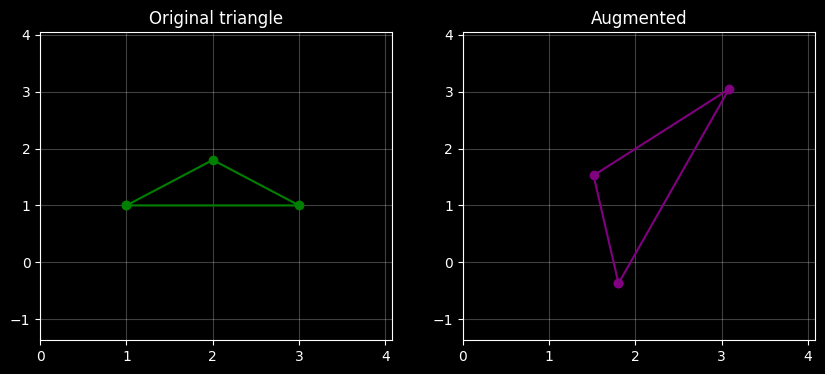

In [6]:
# Testing distortions 
# - - - - - - - - - -

fig, axes = plt.subplots(1, 2, figsize = (10, 4))

triangle = [1,1, 3,1, 2, 1.8]
new_triangle = rotate_triangle(scale_triangle(distort_triangle(triangle, 1, 0.2, 1), 1.5), np.pi/3)

axes[0].plot([triangle[0], triangle[2], triangle[4], triangle[0]], [triangle[1], triangle[3], triangle[5], triangle[1]], color = 'green', marker = 'o')
axes[1].plot([new_triangle[0], new_triangle[2], new_triangle[4], new_triangle[0]], [new_triangle[1], new_triangle[3], new_triangle[5], new_triangle[1]], color = 'purple', marker = 'o')

axes[0].grid(color = 'white', alpha = 0.25)
axes[1].grid(color = 'white', alpha = 0.25)

axes[0].set_title('Original triangle')
axes[1].set_title('Augmented')

xs = (triangle + new_triangle)[::2]
ys = (triangle + new_triangle)[1::2]

axes[0].set_xlim(min(xs) - 1, max(xs) + 1)
axes[0].set_ylim(min(ys) - 1, max(ys) + 1)

axes[1].set_xlim(min(xs) - 1, max(xs) + 1)
axes[1].set_ylim(min(ys) - 1, max(ys) + 1)

plt.show()

In [7]:
# Loading mesh from *.msh file, generated by GMSH
# - - - - - - - - - - - - - - - - - - - - - - - -

nodes, elems, triangles = read_mesh('Kirsch_Fine_6.msh')

[]

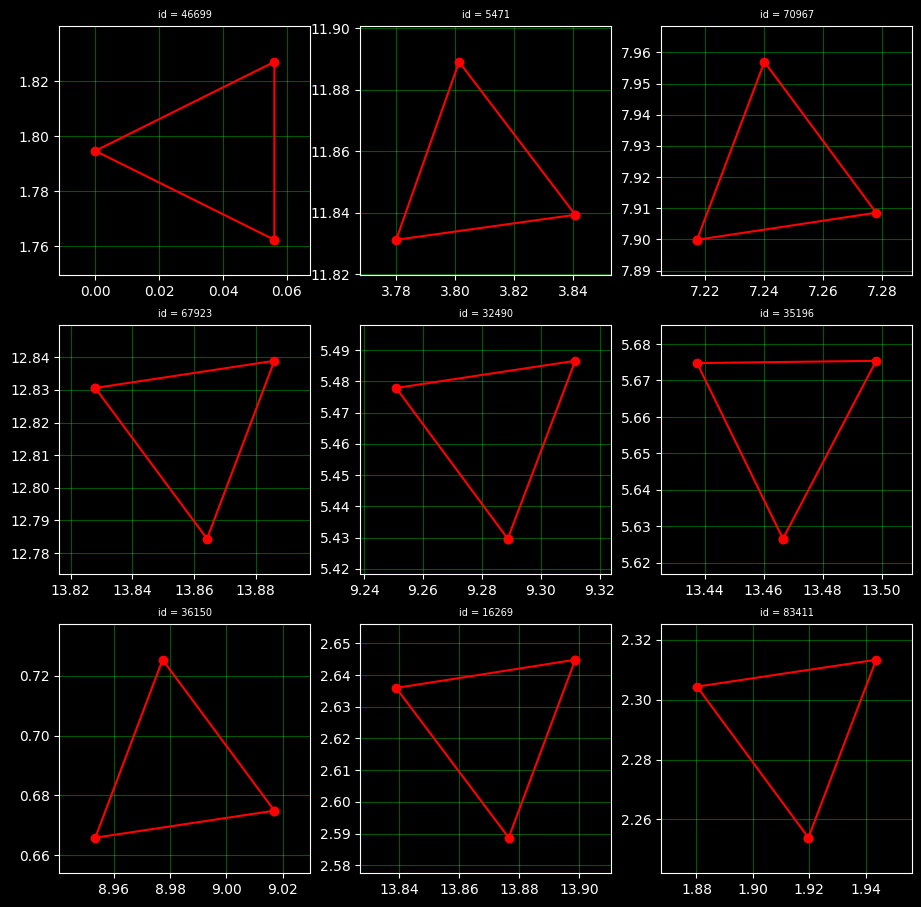

In [8]:
# Inspecting random triangles from mesh
# - - - - - - - - - - - - - - - - - - -

fig, axes = plt.subplots(3,3, figsize = (11, 11))
 
indicies = [np.random.randint(0, len(triangles)-1) for i in range(9)]

for i in range(3):
    for j in range(3):
        idx = 3*i + j
        x1, y1, x2, y2, x3, y3 = triangles[indicies[idx]]

        bounds_x = max(abs(x2 - x1), abs(x3 - x1), abs(x3 - x2))
        bounds_y = max(abs(y2 - y1), abs(y3 - y1), abs(y3 - y2))

        axes[i, j].plot([x1, x2, x3, x1], [y1, y2, y3, y1], color = 'red', marker = 'o')
        axes[i, j].grid(color = 'lime', alpha = 0.35)
        axes[i, j].set_xlim(min(x1,x2,x3) - 0.2*bounds_x, max(x1,x2,x3) + 0.2*bounds_x)
        axes[i, j].set_ylim(min(y1,y2,y3) - 0.2*bounds_y, max(y1,y2,y3) + 0.2*bounds_y)

        axes[i, j].set_title(f'id = {indicies[idx]}', fontsize = 7)

plt.plot()

In [9]:
# Augmenting triangles with factor 3 and choosing randomly some samples for training
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

augmented = augment(triangles, 3)
print(f'Total samples number: {len(augmented)}')

Total samples number: 351563


In [10]:
N_samples = 200000

train_triangs = [augmented[random.randint(0, len(augmented)-1)] for i in range(N_samples)]

[]

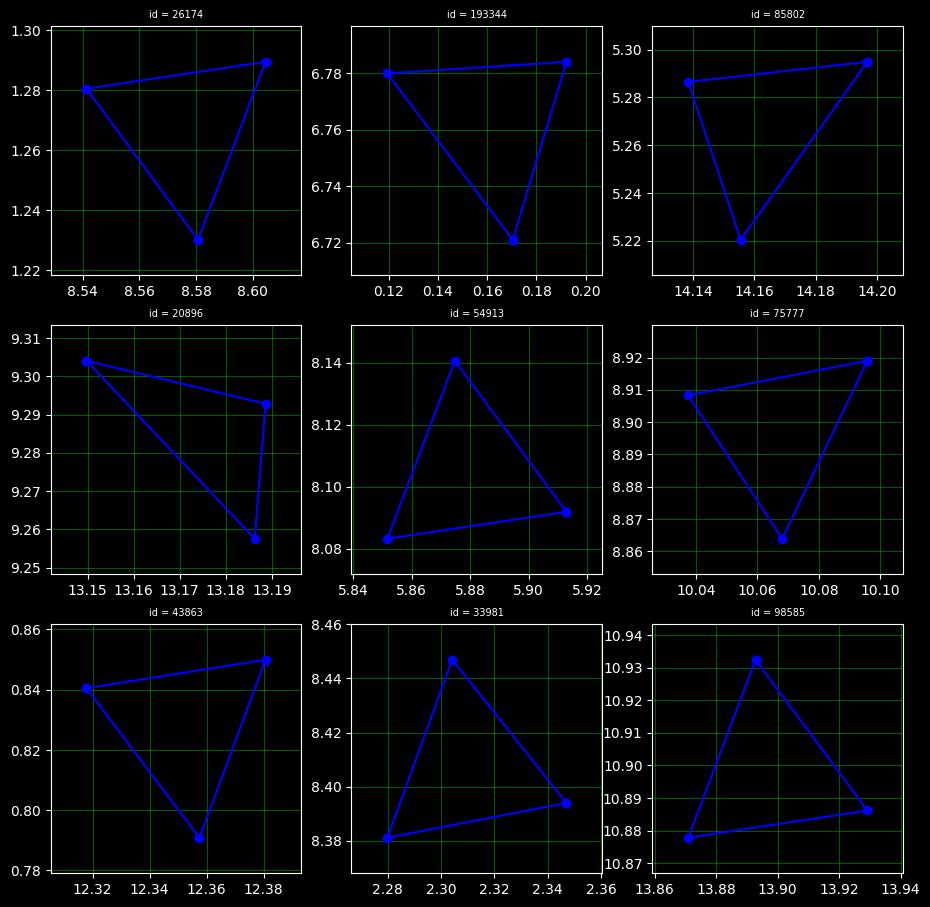

In [11]:
# Inspecting random triangles from augmented samples
# - - - - - - - - - - - - - - - - - - - - - - - - - -

fig, axes = plt.subplots(3,3, figsize = (11, 11))

indicies = [np.random.randint(0, len(train_triangs)-1) for i in range(9)]

for i in range(3):
    for j in range(3):
        idx = 3*i + j
        x1, y1, x2, y2, x3, y3 = train_triangs[indicies[idx]]

        bounds_x = max(abs(x2 - x1), abs(x3 - x1), abs(x3 - x2))
        bounds_y = max(abs(y2 - y1), abs(y3 - y1), abs(y3 - y2))

        axes[i, j].plot([x1, x2, x3, x1], [y1, y2, y3, y1], color = 'blue', marker = 'o')
        axes[i, j].grid(color = 'lime', alpha = 0.35)
        axes[i, j].set_xlim(min(x1,x2,x3) - 0.2*bounds_x, max(x1,x2,x3) + 0.2*bounds_x)
        axes[i, j].set_ylim(min(y1,y2,y3) - 0.2*bounds_y, max(y1,y2,y3) + 0.2*bounds_y)

        axes[i, j].set_title(f'id = {indicies[idx]}', fontsize = 7)

plt.plot()

In [12]:
# Assemblying train stiffness matricies
# - - - - - - - - - - - - - - - - - - -

K_train = []

for triangle in train_triangs:
    K_train.append(local_K(triangle))

In [13]:
# Saving as pickle object
# - - - - - - - - - - - -

with open('K_data.pkl', 'wb') as f:
    pickle.dump(K_train, f)

with open('X_data.pkl', 'wb') as f:
    pickle.dump(train_triangs, f)